#### 1. Importing Libraries

In [ ]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from keras.layers import *
from keras.losses import *
from keras.models import *
from keras.metrics import *
from keras.optimizers import *
from keras.applications import *
from keras.utils import load_img

# For Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt


# Miscellaneous
import pandas as pd
from tqdm import tqdm
import os
import random

In [2]:
import tensorflow as tf

# Set the seed for random number generators in numpy, random, and tensorflow
seed_value = 33
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

#### 2. Data Preparation

##### 2.1 Training dataset

In [3]:
train_data = pd.read_csv("../../../pre_processed_data/Training/train.csv")

# Extracting paths and labels from the Training dataframe
train_paths = train_data['Path'].tolist()
train_labels = train_data['Label'].tolist()

# Shuffling the paths and labels
train_paths, train_labels = shuffle(train_paths, train_labels)

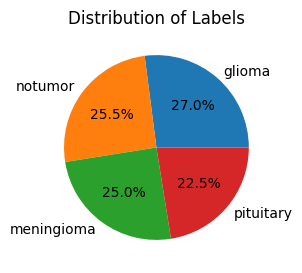

In [4]:
# Plotting a pie chart for the 'label' column
label_counts = train_data['Label'].value_counts()
plt.figure(figsize=(3, 3))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Labels')
plt.show()

##### 2.2 Testing dataset

In [5]:
test_data = pd.read_csv("../../../pre_processed_data/Testing/test.csv")

# Extracting paths and labels from the Testing dataframe
test_paths = test_data['Path'].tolist() 
test_labels = test_data['Label'].tolist()

# Shuffling the paths and labels
test_paths, test_labels = shuffle(test_paths, test_labels)

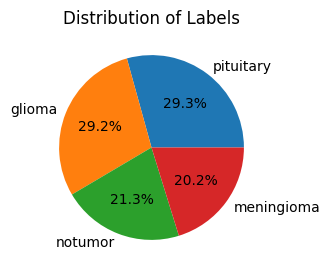

In [6]:
# Plotting a pie chart for the 'label' column
label_counts = test_data['Label'].value_counts()
plt.figure(figsize=(3, 3))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Labels')
plt.show()

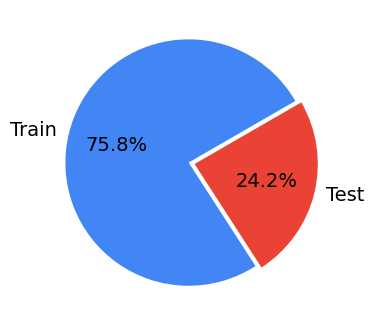

In [7]:
plt.figure(figsize=(8,4))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

##### 3.1 Examples

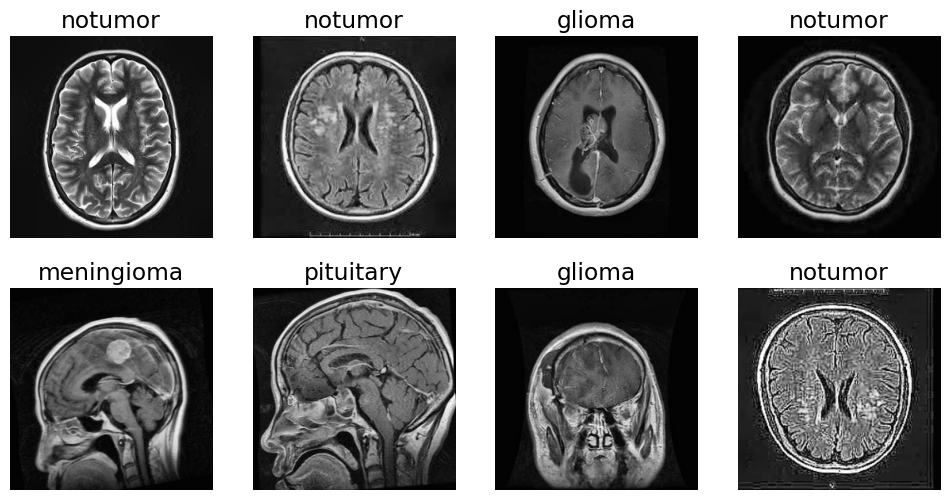

In [8]:
IMAGE_SIZE = 256

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = np.array(image)  # Convert the image to a NumPy array
        images.append(image)
    return np.array(images)

# Assuming train_paths and train_labels are defined
images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

#### 4. Data Generator
Given a list of paths to images, and the labels, this function encodes the label, and then returns the batch on which the model can train on.

In [9]:
unique_labels = list(set(train_labels))

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

#### 5. Model `VGG19`

In [ ]:
base_model = VGG19(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')

# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [11]:
batch_size = 32
steps = int(len(train_paths)/batch_size)
epochs = 5
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/5


100/100 [==============================] - 4119s 41s/step - loss: 1.0639 - sparse_categorical_accuracy: 0.7706
Epoch 2/5
100/100 [==============================] - 4467s 45s/step - loss: 0.2837 - sparse_categorical_accuracy: 0.8980
Epoch 3/5
100/100 [==============================] - 4456s 45s/step - loss: 0.2340 - sparse_categorical_accuracy: 0.9172
Epoch 4/5
100/100 [==============================] - 4607s 46s/step - loss: 0.1858 - sparse_categorical_accuracy: 0.9313
Epoch 5/5
100/100 [==============================] - 4575s 46s/step - loss: 0.1305 - sparse_categorical_accuracy: 0.9550


#### 6. Evaluation

In [ ]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

In [13]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.92      0.96      0.94       299
  meningioma       0.87      0.84      0.86       207
     notumor       0.98      0.99      0.99       218
   pituitary       0.98      0.94      0.96       300

    accuracy                           0.94      1024
   macro avg       0.94      0.93      0.94      1024
weighted avg       0.94      0.94      0.94      1024



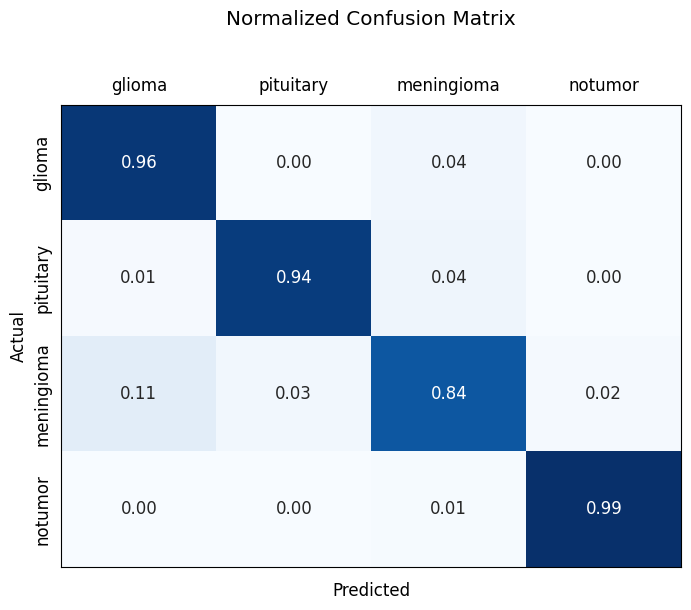

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming y_true and y_pred are defined in your code
# If not, replace them with your actual data

# Concatenate the lists to get a single set
all_labels = list(set(y_true + y_pred))

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=all_labels)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a subplot with shared y-axis
fig, ax = plt.subplots(figsize=(8, 6), sharey=True)

# Plot the normalized confusion matrix using Seaborn heatmap
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=all_labels, yticklabels=all_labels, cbar=False, ax=ax)
ax.set_title("Normalized Confusion Matrix\n\n")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")

# Move the x-axis ticks to the top
ax.tick_params(axis='x', which='both', bottom=False, top=True)

# Add a second set of x-axis labels at the top
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ax.get_xticks())
ax2.set_xticklabels(all_labels, ha='center')

# Remove x-axis labels at the bottom
ax.set_xticklabels([])
ax.tick_params(axis='x', which='both', bottom=False, top=False)
ax2.tick_params(axis='x', which='both', bottom=False, top=False)
ax.tick_params(axis='y', which='both', left=False, right=False)

# Save and display the plot
plt.savefig(f'confusion_matrix_{seed_value}.png')
plt.show()



In [35]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Concatenate the lists to get a single set
all_labels = list(set(y_true + y_pred))

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=all_labels, normalize='true')

# Save normalized confusion matrix in an array
conf_matrix_array = np.array(conf_matrix_normalized)

# Display the normalized confusion matrix array
print("Normalized Confusion Matrix Array:")
print(conf_matrix_array)

Normalized Confusion Matrix Array:
[[0.84280936 0.00668896 0.15050167 0.        ]
 [0.         0.97333333 0.02666667 0.        ]
 [0.01932367 0.07246377 0.88888889 0.01932367]
 [0.00458716 0.         0.01376147 0.98165138]]


# Fine-Tuning on real+synthetic mix

In [15]:
generated_csv_path = '../../diffusion models/generated_images/generated.csv'

generated_data = pd.read_csv(generated_csv_path)

# Extracting paths and labels
generated_paths = generated_data['Path'].tolist()
generated_labels = generated_data['Label'].tolist()

# Optionally shuffle them
generated_paths, generated_labels = shuffle(generated_paths, generated_labels)

In [16]:
# Example: Combine 50% real data with synthetic data
half_real_index = len(train_paths) // 2
combined_paths = train_paths[:half_real_index] + generated_paths
combined_labels = train_labels[:half_real_index] + generated_labels

combined_paths, combined_labels = shuffle(combined_paths, combined_labels)

In [17]:
# Fine-tuning parameters
fine_tune_batch_size = 32
fine_tune_steps = int(len(combined_paths) / fine_tune_batch_size)
fine_tune_epochs = 3  # You can adjust the number of epochs

# Fine-tuning the model
history_fine_tune = model.fit(
    datagen(combined_paths, combined_labels, batch_size=fine_tune_batch_size, epochs=fine_tune_epochs),
    epochs=fine_tune_epochs, steps_per_epoch=fine_tune_steps
)

Epoch 1/3
125/125 [==============================] - 5290s 42s/step - loss: 0.1410 - sparse_categorical_accuracy: 0.9532
Epoch 2/3
125/125 [==============================] - 5558s 45s/step - loss: 0.0414 - sparse_categorical_accuracy: 0.9861
Epoch 3/3
125/125 [==============================] - 5570s 45s/step - loss: 0.0286 - sparse_categorical_accuracy: 0.9894


In [ ]:
# Evaluation on the test set
test_batch_size = 32
test_steps = int(len(test_paths) / test_batch_size)
y_pred_fine_tune = []
y_true_fine_tune = []

for x, y in tqdm(datagen(test_paths, test_labels, batch_size=test_batch_size, epochs=1), total=test_steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred_fine_tune.append(i)
    for i in decode_label(y):
        y_true_fine_tune.append(i)

In [19]:
print(classification_report(y_true_fine_tune, y_pred_fine_tune))

              precision    recall  f1-score   support

      glioma       0.98      0.84      0.91       299
  meningioma       0.77      0.89      0.82       207
     notumor       0.98      0.98      0.98       218
   pituitary       0.94      0.97      0.96       300

    accuracy                           0.92      1024
   macro avg       0.92      0.92      0.92      1024
weighted avg       0.93      0.92      0.92      1024



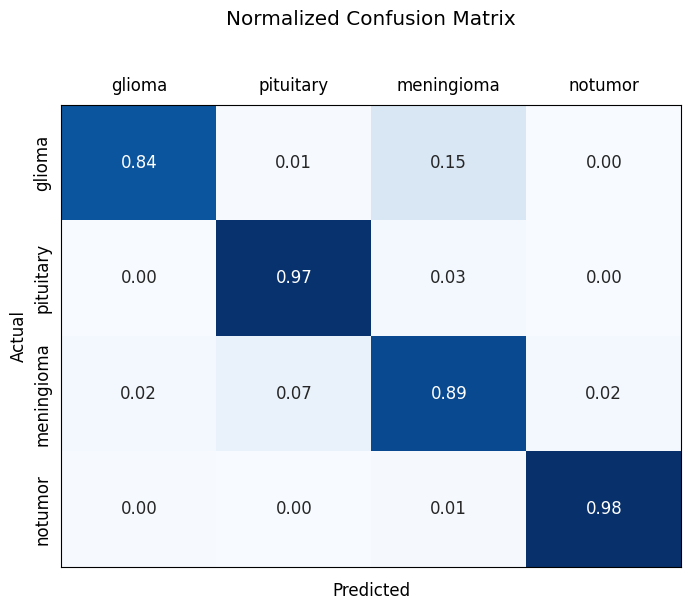

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming y_true and y_pred are defined in your code
# If not, replace them with your actual data

# Concatenate the lists to get a single set
all_labels = list(set(y_true_fine_tune + y_pred_fine_tune))

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true_fine_tune, y_pred_fine_tune, labels=all_labels)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a subplot with shared y-axis
fig, ax = plt.subplots(figsize=(8, 6), sharey=True)

# Plot the normalized confusion matrix using Seaborn heatmap
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=all_labels, yticklabels=all_labels, cbar=False, ax=ax)
ax.set_title("Normalized Confusion Matrix\n\n")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")

# Move the x-axis ticks to the top
ax.tick_params(axis='x', which='both', bottom=False, top=True)

# Add a second set of x-axis labels at the top
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ax.get_xticks())
ax2.set_xticklabels(all_labels, ha='center')

# Remove x-axis labels at the bottom
ax.set_xticklabels([])
ax.tick_params(axis='x', which='both', bottom=False, top=False)
ax2.tick_params(axis='x', which='both', bottom=False, top=False)
ax.tick_params(axis='y', which='both', left=False, right=False)

# Save and display the plot
plt.savefig(f'confusion_matrix_FineTuning{seed_value}.png')
plt.show()

In [22]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Concatenate the lists to get a single set
all_labels = list(set(y_true_fine_tune + y_pred_fine_tune))

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true_fine_tune, y_pred_fine_tune, labels=all_labels)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Save confusion matrix in an array
conf_matrix_array = np.array(conf_matrix)

# Display the confusion matrix array
print("Confusion Matrix Array:")
print(conf_matrix_array)


Confusion Matrix Array:
[[252   2  45   0]
 [  0 292   8   0]
 [  4  15 184   4]
 [  1   0   3 214]]


In [32]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Concatenate the lists to get a single set
all_labels = list(set(y_true_fine_tune + y_pred_fine_tune))

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true_fine_tune, y_pred_fine_tune, labels=all_labels, normalize='true')

# Round the values to two decimal places
conf_matrix_normalized_rounded = np.round(conf_matrix, decimals=2)

# Save normalized confusion matrix in an array
conf_matrix_normalized_array = np.array(conf_matrix_normalized)

# Display the normalized confusion matrix array
print("Normalized Confusion Matrix Array:")
print(conf_matrix_normalized_array)


Normalized Confusion Matrix Array:
[[0.84280936 0.00668896 0.15050167 0.        ]
 [0.         0.97333333 0.02666667 0.        ]
 [0.01932367 0.07246377 0.88888889 0.01932367]
 [0.00458716 0.         0.01376147 0.98165138]]
